## Selecting number of clusters 

In [2]:
import sys
!{sys.executable} -m pip install kneed

In [3]:
# sklearn imports
from sklearn.datasets import load_iris
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# pandas and numpy imports
import pandas as pd
import numpy as np

# plotting imports
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# import knee detection algorithm
from kneed import KneeLocator

# set sns theme and set pandas to display all rows and columns
sns.set_theme()

### Load Iris dataset 

In [4]:
# Load iris dataset
iris = load_iris()

iris_df = pd.DataFrame(
    iris['data'],
    columns=iris['feature_names']
)


# Add label to the dataset
iris_df['label'] = iris['target_names'][iris['target']]

# Remove versicolor class
iris_df = iris_df[iris_df['label'] != 'versicolor']

# Keep only petal length and petal width
iris_df = iris_df.filter(
    items=[
        'petal length (cm)', 
        'petal width (cm)', 
        'label'
    ]
)

Text(0.5, 1.0, 'Raw data')

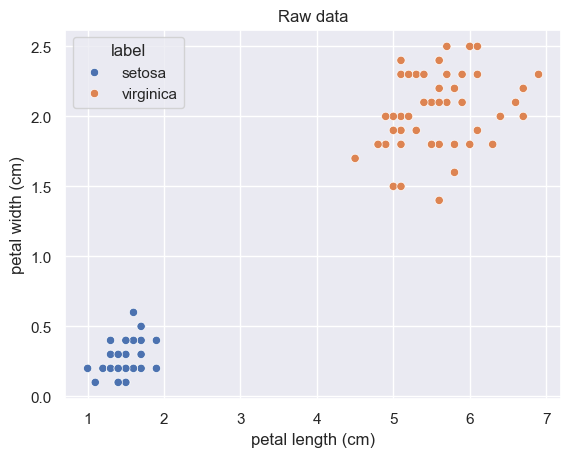

In [5]:
sns.scatterplot(
    iris_df, 
    x='petal length (cm)', 
    y='petal width (cm)', 
    hue='label'
)

plt.title('Raw data')

## Selecting optimal number of clusters - inertia knee plot

In this section we sill Elbow (Knee) Method for Inertia to analyze clustering quality.

Elbow (Knee) Method for Inertia is a technique used to determine the optimal number of clusters (k) in K-means clustering by plotting the inertia (sum of squared distances of data points to their closest cluster center) against different k values, and selecting the k where the rate of decrease in inertia sharply changes, resembling an "elbow" in the curve.

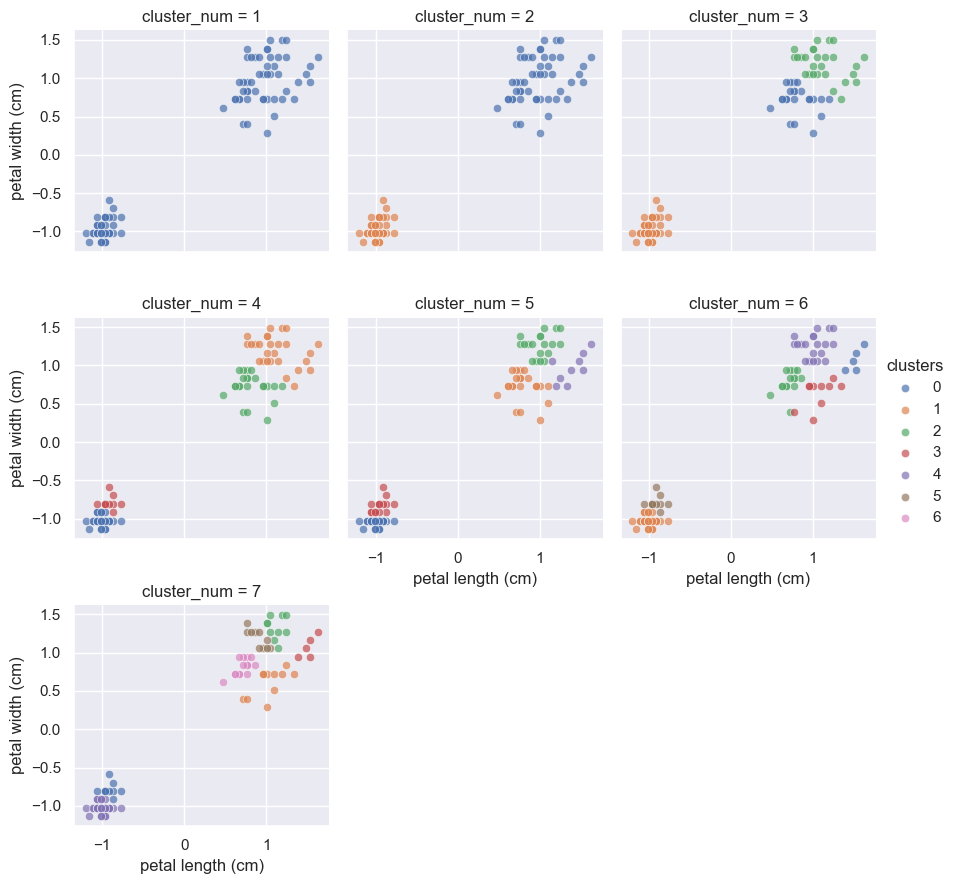

In [9]:
# Set up multiple values of k 
num_clusters = [1,2,3,4,5,6,7]

# List used to store inertia
inertia_list = []
# List used to store clusters
clustering_result_list = []

# Set up standard scaler
cluster_data = iris_df[['petal length (cm)', 'petal width (cm)']]

# Standardize the data
standard_scaler = StandardScaler()
standard_scaler.fit(cluster_data)
cluster_data = standard_scaler.transform(cluster_data)
cluster_data = pd.DataFrame(
    cluster_data, 
    columns = ['petal length (cm)', 'petal width (cm)']
)

# Perform clustering for multiple resolutons
for num_clust in num_clusters:
    
    # Perform clustering for current number of clusters
    kmeans = KMeans(n_clusters=num_clust, n_init='auto')
    kmeans.fit(cluster_data)
    
    # Calculate inertia
    inertia_list.append(kmeans.inertia_)
    
    # Add clustering result to the list
    current_clustering = cluster_data.copy()
    current_clustering['clusters'] = kmeans.labels_
    current_clustering['cluster_num'] = num_clust
    clustering_result_list.append(current_clustering)
    
# Merge results for all values of num_clust
merged_clustering_result = pd.concat(
    clustering_result_list, 
    axis=0, 
    ignore_index=True
)

# Plot all clusterings
g = sns.FacetGrid(
    merged_clustering_result, 
    col="cluster_num", 
    col_wrap=3, 
    hue="clusters"
)
g.map(
    sns.scatterplot, 
    'petal length (cm)', 
    'petal width (cm)', 
    alpha=.7
)
g.add_legend()    

In this situation inertia-knee method does bad job of separating the clusters. We use **kneedle** library for automatic knee detection.

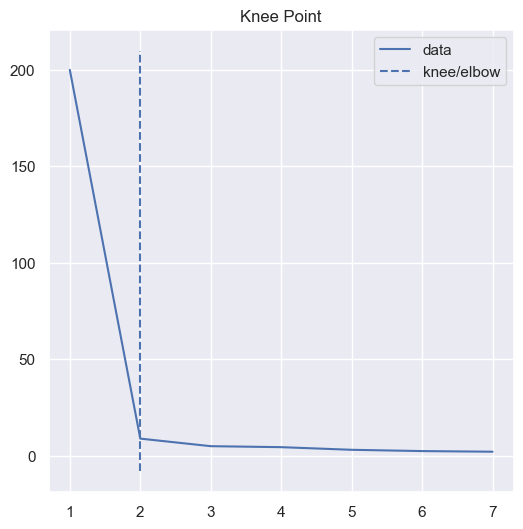

In [10]:
kneedle = KneeLocator(
    num_clusters, 
    inertia_list, 
    curve="convex", 
    direction="decreasing"
)
kneedle.plot_knee()

## Selecting optimal number of clusters - siluethe score

In this section we sill use Silhouette Score to analyze clustering quality.

Silhouette Score is a metric that measures the quality of a clustering solution by calculating the average silhouette coefficient for each data point, which considers both cohesion (how close points are within a cluster) and separation (how distinct clusters are from each other), with values ranging from -1 (poor clustering) to 1 (well-defined clusters).



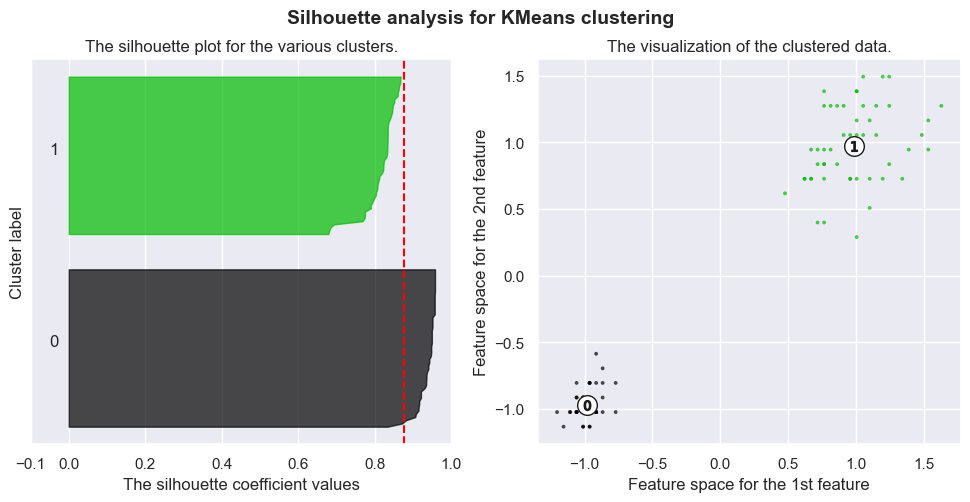

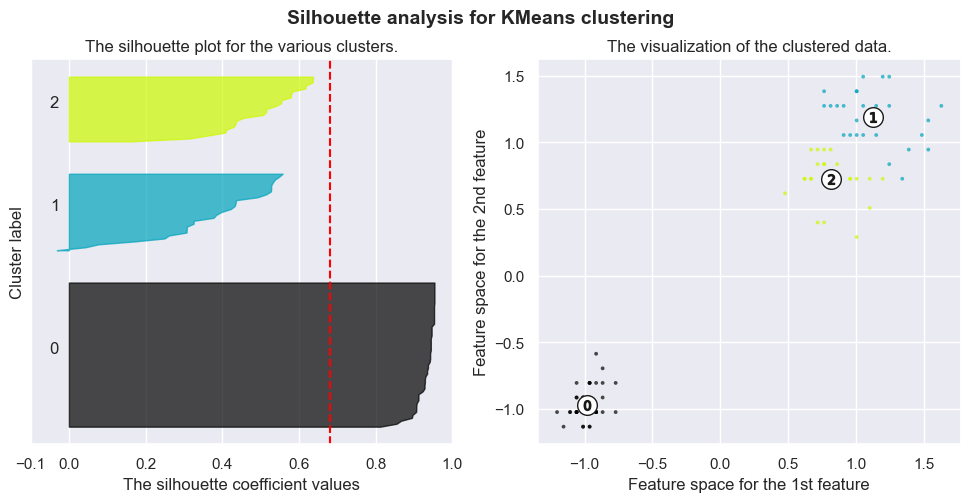

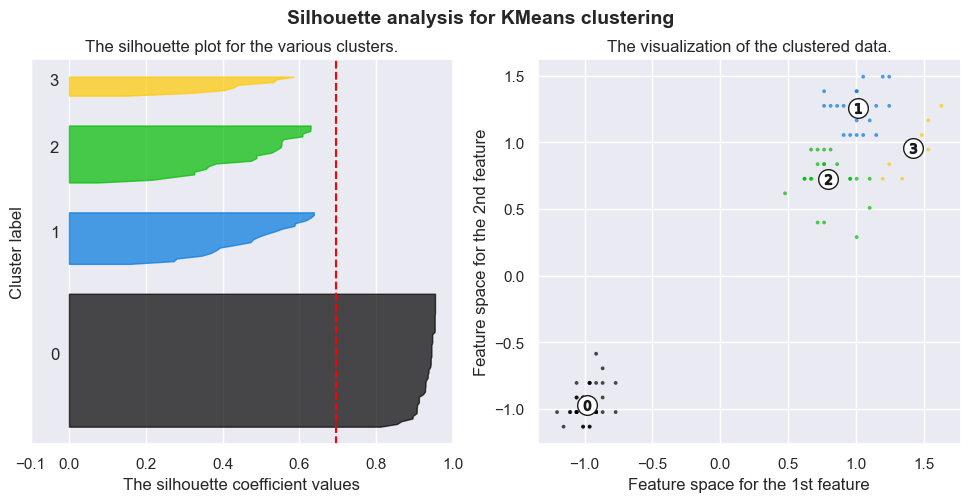

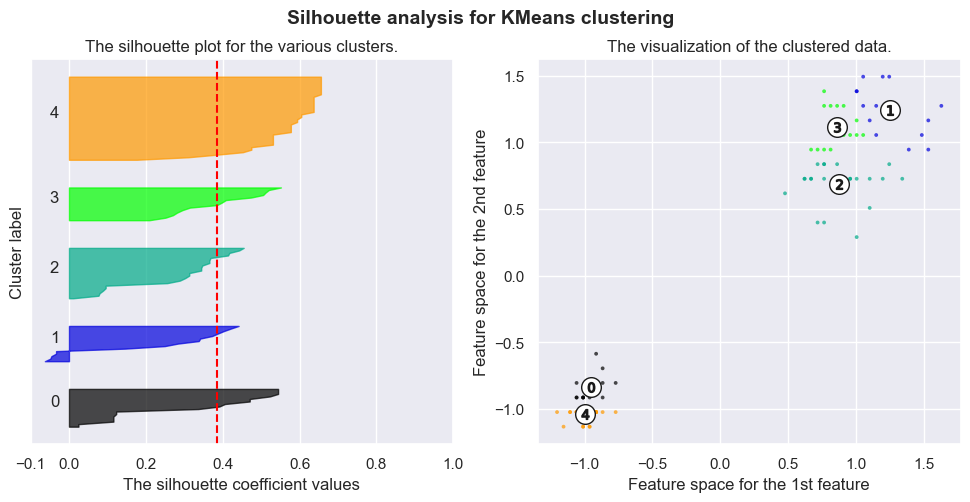

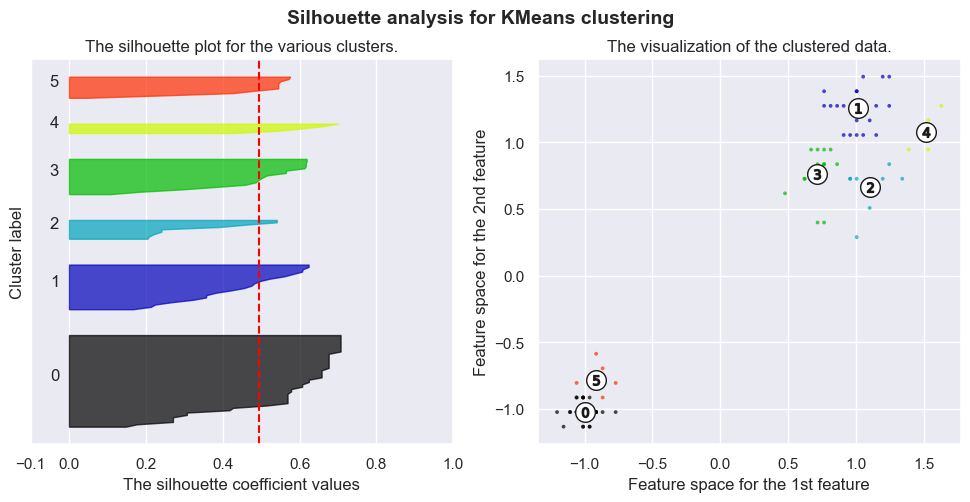

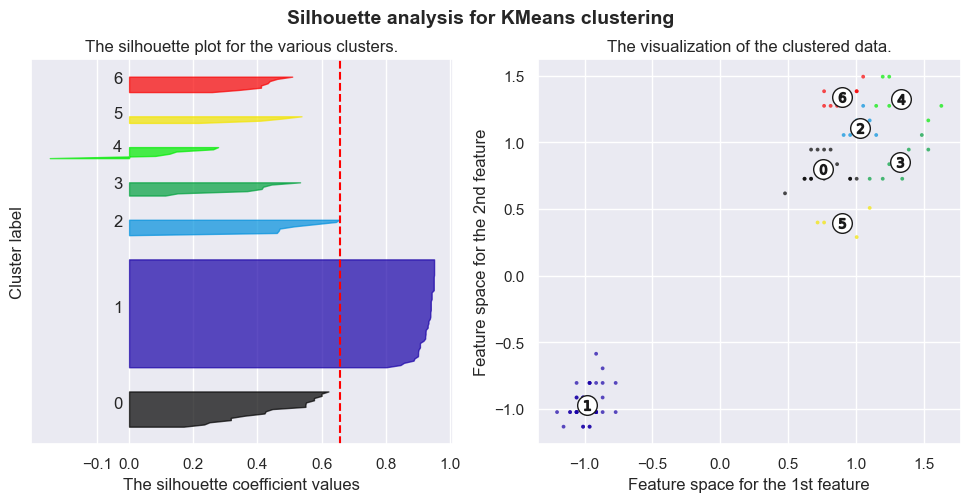

In [12]:
# Set up multiple values of k
num_clusters = [2,3,4,5,6,7]

# Lists for storing results
silouethe_score_list = []

# Set up standard scaler
cluster_data = iris_df[['petal length (cm)', 'petal width (cm)']]

standard_scaler = StandardScaler()
standard_scaler.fit(cluster_data)
cluster_data = standard_scaler.transform(cluster_data)
cluster_data = pd.DataFrame(
    cluster_data, 
    columns = ['petal length (cm)', 'petal width (cm)']
)

# Perform clustering for multiple resolutons

# Lower y coordinate for the first silhouette plot
y_lower = 10

for num_clust in num_clusters:
    
    # Perform clustering for current number of clusters
    kmeans = KMeans(n_clusters=num_clust, n_init='auto')
    kmeans.fit(cluster_data)
        
    # Calculate average silhouette score
    silhouette_scr = silhouette_score(cluster_data, kmeans.labels_)
    silouethe_score_list.append(silhouette_scr)
    # Calculate silhouette score for each data point
    sample_silhouette_values = silhouette_samples(cluster_data, kmeans.labels_)
    
    # Plot clustering and silouethes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    
    # Plot siluethe scores for points belonging to each cluster
    for clust_i in range(num_clust):
        
        # Get points bellogning to the current cluster
        ith_cluster_silhouette_values = sample_silhouette_values[
            kmeans.labels_ == clust_i
        ]
        
        # Sort points by silhouette value
        ith_cluster_silhouette_values.sort()
        
        # Get size of current cluster
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        
        # Get upper value of y cooridnate for current cluster
        y_upper = y_lower + size_cluster_i
        
        # Fill values between y_lower and y_upper with silhouette score values
        # for data points
        color = cm.nipy_spectral(float(clust_i) / num_clust)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )
        
        # Label the silhouette plots with their cluster numbers 
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(clust_i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10
    
    # Set title and labels silhouette subplot
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_scr, color="red", linestyle="--")

    # Clear the yaxis labels / ticks
    ax1.set_yticks([]) 
    # Set x-ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # Map cluster labels to cluster colors, nipy_spectral provides
    # colors evenly distributed across the entire range of values.
    colors = cm.nipy_spectral(kmeans.labels_.astype(float) / num_clust)
    
    # 2nd Plot showing the actual clustering scatteplot
    ax2.scatter(
        cluster_data.values[:, 0], 
        cluster_data.values[:, 1],
        marker=".", s=30, lw=0, 
        alpha=0.7, c=colors, 
        edgecolor="k"
    )

    # Get cluster centers
    centers = kmeans.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, s=50, edgecolor="k")

    # Set title and labels for scatterplot
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    
    # Add main title
    plt.suptitle(
        "Silhouette analysis for KMeans clustering",
        fontsize=14,
        fontweight="bold",
    )

# Show the plot
plt.show()

Text(0, 0.5, 'Silhouette score value')

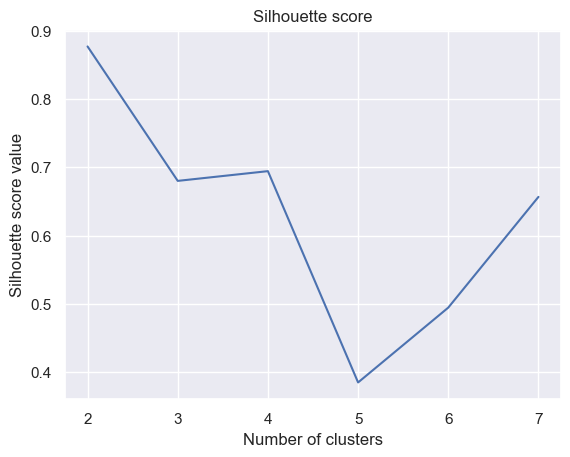

In [13]:
# Overall siluethe scores
plt.plot(num_clusters, silouethe_score_list)
plt.title('Silhouette score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score value')


## Artificial dataset - 5 clusters - case 1

In this section we will perform clustering on artificial dataset created with **make_blobs** function.

**make_blobs** is a function provided by the scikit-learn (sklearn) library in Python, which is used to generate synthetic datasets for clustering or classification tasks. It creates a set of Gaussian blobs with controllable properties such as the number of blobs, their centroids, standard deviations, and the total number of samples.

In [14]:
from sklearn.datasets import make_blobs

X, y_true = make_blobs(
    n_samples=500, centers=5, cluster_std=0.60, random_state=1
)

In [15]:
artificial_df = pd.DataFrame(data=X, columns=['Feature 1', 'Feature 2'])

<Axes: xlabel='Feature 1', ylabel='Feature 2'>

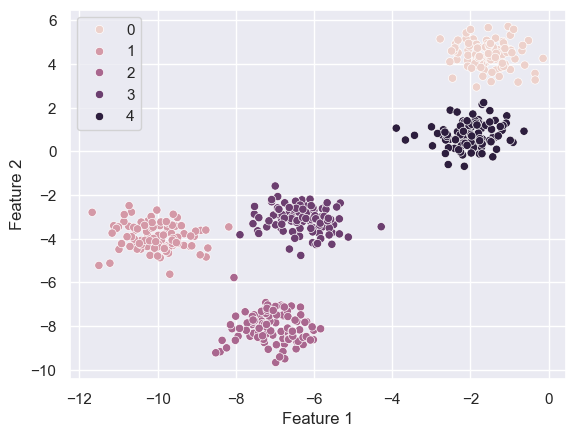

In [16]:
sns.scatterplot(artificial_df, x='Feature 1', y='Feature 2', hue=y_true)

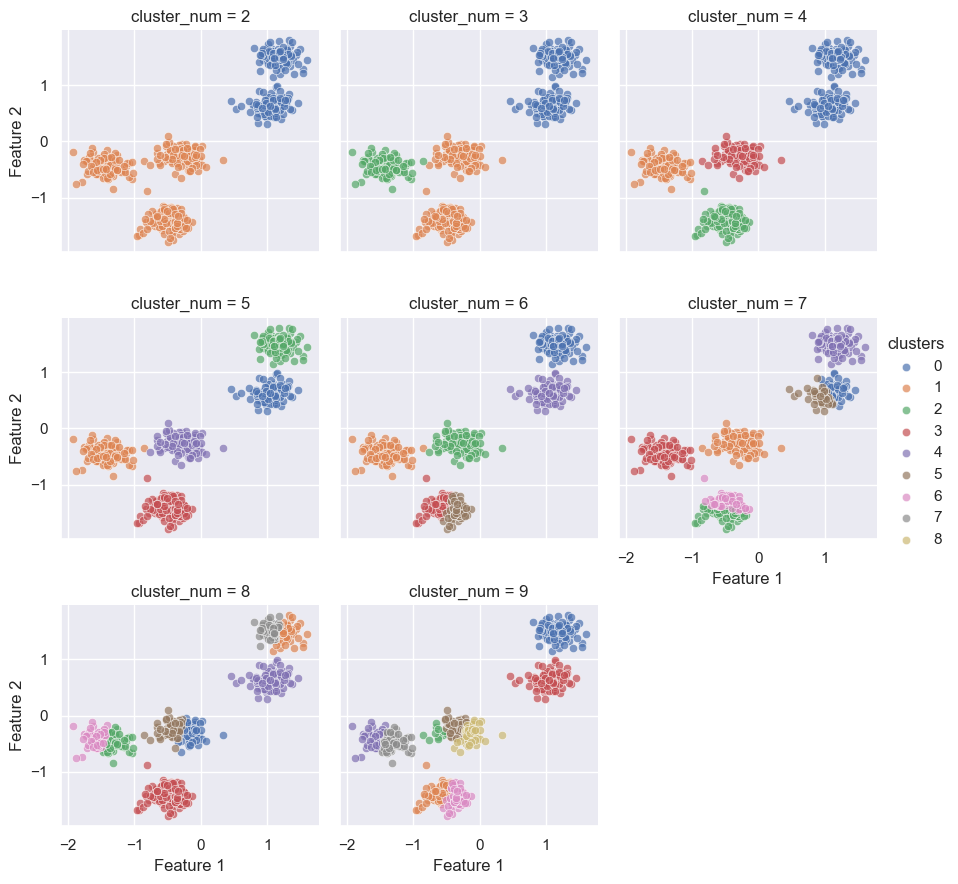

In [17]:
# Different numbers of k to try out
num_clusters = [2,3,4,5,6,7,8,9]
# Storage for inertia value
inertia_list = []
# Storage for silhouette scores
silhouette_score_list = []
# List used to store clustering results
clustering_result_list = []

# Use StandardScaler to standardize data
standard_scaler = StandardScaler()
artificial_df = standard_scaler.fit_transform(artificial_df)
artificial_df = pd.DataFrame(
    data=artificial_df, 
    columns=['Feature 1', 'Feature 2']
)

# Perform clustering for different number of clusters
for num_clust in num_clusters:
    
    # Perform k means clustering
    kmeans = KMeans(n_clusters=num_clust, n_init='auto')
    kmeans.fit(artificial_df)
    
    # Calculate and store inertia & silhouette score
    inertia_list.append(kmeans.inertia_)
    silhouette_scr = silhouette_score(artificial_df, kmeans.labels_)
    silhouette_score_list.append(silhouette_scr)
    
    # Add clustering result to list
    current_clustering = artificial_df.copy()
    current_clustering['clusters'] = kmeans.labels_
    current_clustering['cluster_num'] = num_clust
    clustering_result_list.append(current_clustering)
    
# Merge results for all values of num_clust
merged_clustering_result = pd.concat(
    clustering_result_list, 
    axis=0, 
    ignore_index=True
)

# Plot all clusterings
g = sns.FacetGrid(
    merged_clustering_result, 
    col="cluster_num", 
    col_wrap=3, 
    hue="clusters"
)
g.map(
    sns.scatterplot, 
    'Feature 1', 
    'Feature 2', 
    alpha=.7
)
g.add_legend()    

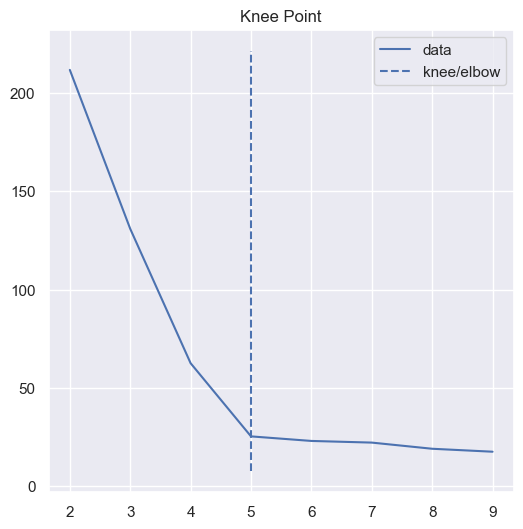

In [18]:
# Plot inertia
kneedle = KneeLocator(
    num_clusters, 
    inertia_list, 
    curve="convex", 
    direction="decreasing"
)
kneedle.plot_knee()

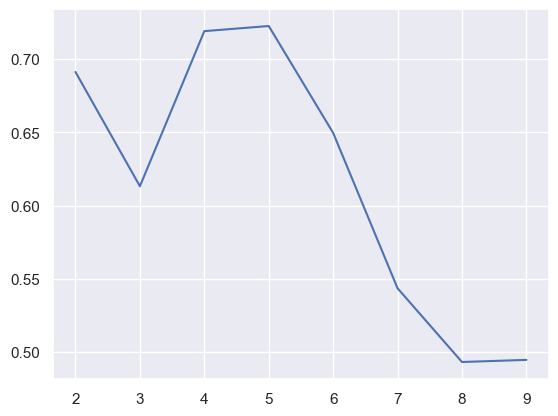

In [19]:
plt.plot(num_clusters, silhouette_score_list)

## Artificial dataset - 5 clusters - case 2

In this section we will perform clustering on another artificial dataset.

<Axes: xlabel='Feature 1', ylabel='Feature 2'>

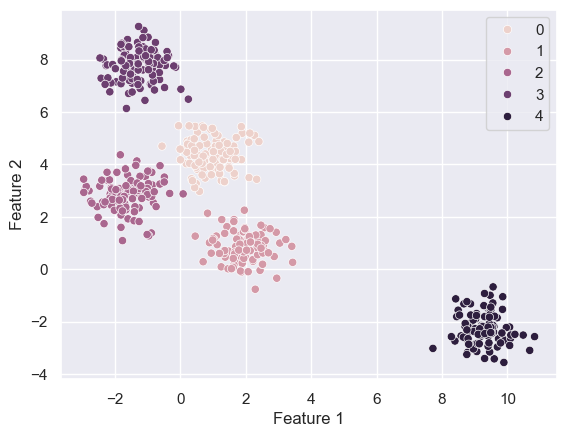

In [20]:
from sklearn.datasets import make_blobs

X, y_true = make_blobs(
    n_samples=500, centers=5, cluster_std=0.6, random_state=0
)

artificial_df = pd.DataFrame(data=X, columns=['Feature 1', 'Feature 2'])

sns.scatterplot(artificial_df, x='Feature 1', y='Feature 2', hue=y_true)

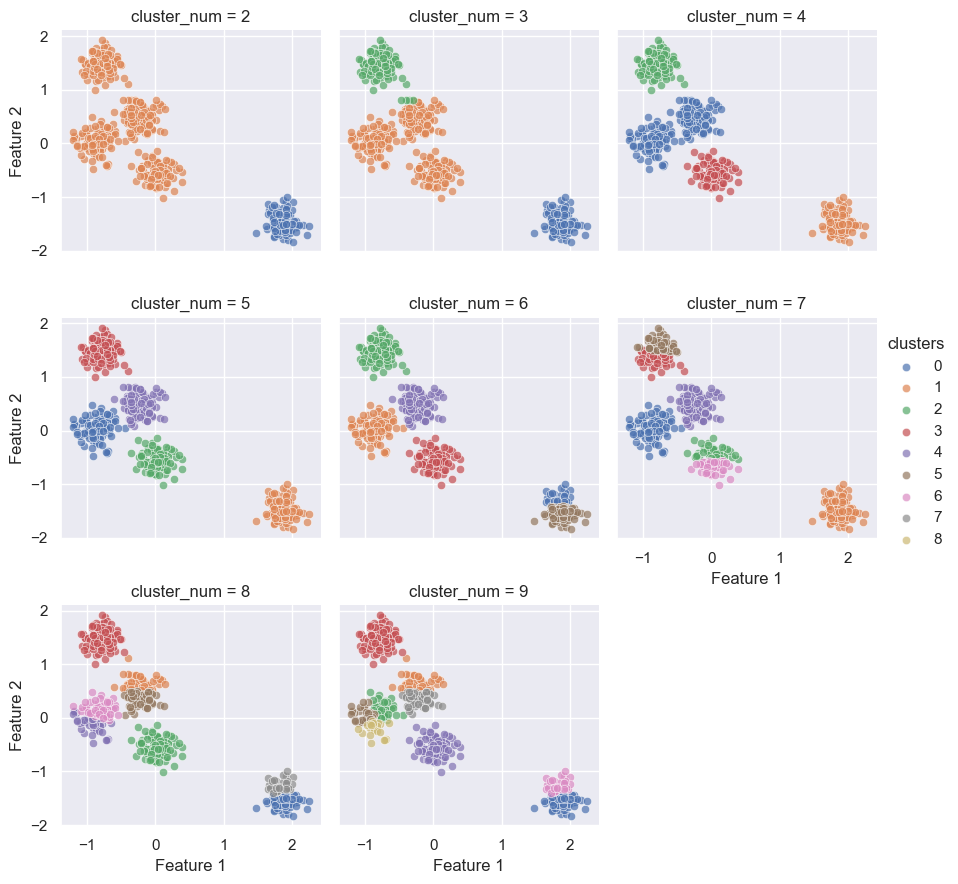

In [21]:
# Various number of clusters
num_clusters = [2,3,4,5,6,7,8,9]
# List to store inertia values
inertia_list = []
# List to store silhouette scores
silhouette_score_list = []

# List used to store clusterings
clustering_result_list = []

# Use StandardScaler to standardize data
standard_scaler = StandardScaler()
artificial_df = standard_scaler.fit_transform(artificial_df)
artificial_df = pd.DataFrame(
    data=artificial_df, 
    columns=['Feature 1', 'Feature 2']
)

# Perform clustering for different number of clusters
for num_clust in num_clusters:
    
    # Perform k means clustering
    kmeans = KMeans(n_clusters=num_clust, n_init='auto')
    kmeans.fit(artificial_df)
    
    # Calculate and store inertia & silhouette score
    inertia_list.append(kmeans.inertia_)
    silhouette_scr = silhouette_score(artificial_df, kmeans.labels_)
    silhouette_score_list.append(silhouette_scr)
    
    # Add clustering result to the list
    current_clustering = artificial_df.copy()
    current_clustering['clusters'] = kmeans.labels_
    current_clustering['cluster_num'] = num_clust
    clustering_result_list.append(current_clustering)
    
# Merge results for all values of num_clust
merged_clustering_result = pd.concat(
    clustering_result_list, 
    axis=0, 
    ignore_index=True
)

# Plot all clusterings
g = sns.FacetGrid(
    merged_clustering_result, 
    col="cluster_num", 
    col_wrap=3, 
    hue="clusters"
)
g.map(
    sns.scatterplot, 
    'Feature 1', 
    'Feature 2', 
    alpha=.7
)
g.add_legend()    

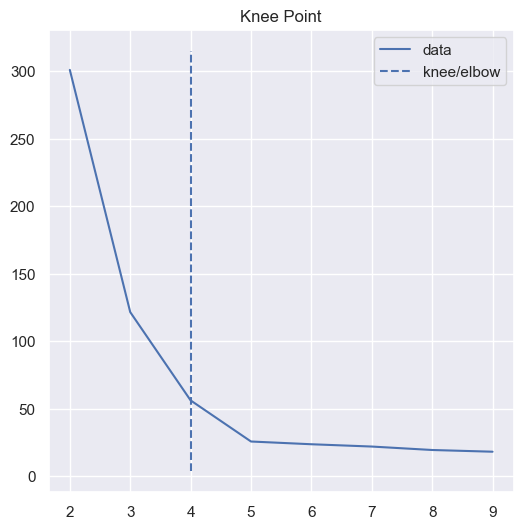

In [22]:
# Plot inertia plot and curve
kneedle = KneeLocator(
    num_clusters, 
    inertia_list, 
    S=2, 
    curve="convex", 
    direction="decreasing"
)
kneedle.plot_knee()

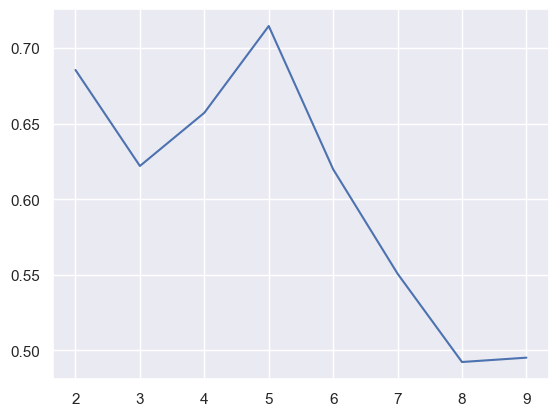

In [23]:
plt.plot(num_clusters, silhouette_score_list)